#1. 흐름 이해

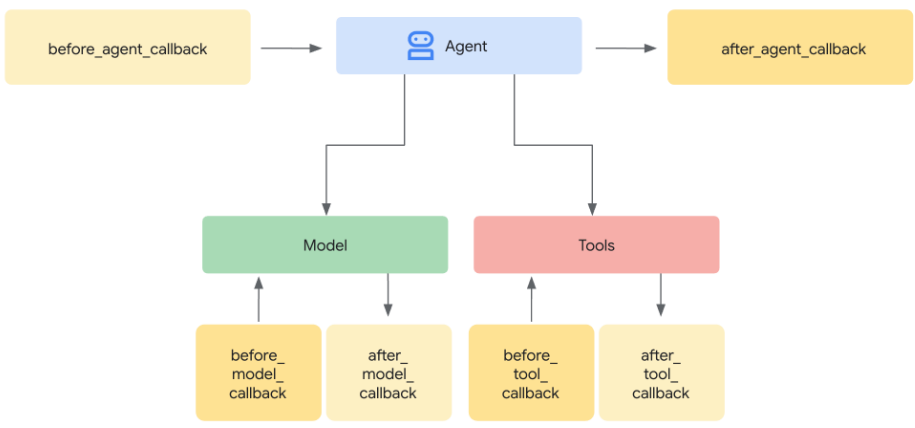

#2. Agent callback

##2.1 흐름 이해

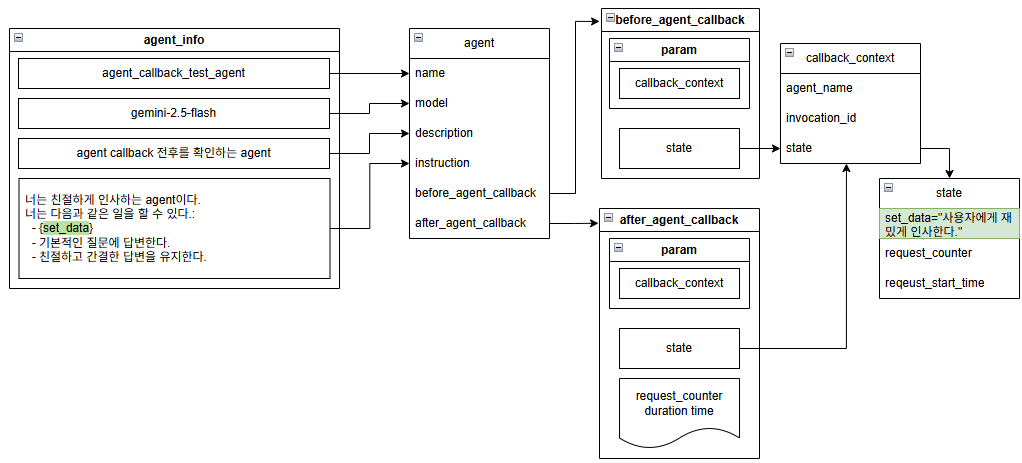

##2.2 코드 분석

##2.2.1 agent_info.py

In [ ]:
# agent_info.py
NAME="agent_callback_test_agent"
MODEL="gemini-2.5-flash"
DESCRIPTION="agent callback 전, 후를 확인하는 agent"
def get_instruction(set_data:str) -> str:
    return f"""
        너는 친절하게 인사하는 agent이다.

        너는 다음과 같은 일을 할 수 있다.:
        - {set_data}
        - 기본적인 질문에 답변한다.
        - 친절하고 간결한 답변을 유지한다.
    """

##2.2.2 agent.py

In [ ]:
from google.adk.agents.llm_agent import Agent
from . import agent_info as info
from .agent_info import get_instruction
from google.adk.agents.callback_context import CallbackContext
from google.genai import types

from datetime import datetime
from typing import Optional

def before_agent_callback(callback_context:CallbackContext) -> Optional[types.Content]:
    """
    이 함수는 agent 호출 전 사용되는 함수이다.

    args:
        callback_context:
            agent이름과 식별 ID 그리고 state 정보를 key value 형식으로 저장한다.
    returns:
        None
    """
    print("\n\n===== before agent callback =====")
    print(f"agent name : {callback_context.agent_name}")
    print(f"agent id : {callback_context.invocation_id}")

    # session을 통해 유지할 정보를 설정
    # 여기선 agent를 처리하는 동안의 소요시간을 확인
    state = callback_context.state

    if "set_data" not in state:
        state["set_data"] = "사용자에게 재미있게 인사한다."

    if "request_counter" not in state:
        state["request_counter"] = 1
    else:
        state["request_counter"] += 1

    state["request_start_time"] = datetime.now()


def after_agent_callback(callback_context:CallbackContext) -> Optional[types.Content]:
    """
    이 함수는 agent 호출 후 사용되는 함수이다.

    args:
        callback_context:
            before_agent_callback 함수에서 설정한 값을 확인한다.
    returns:
        None
    """
    print("\n\n===== after agent callback =====")
    state = callback_context.state

    if "request_start_time" in state:
        duration = (datetime.now() - state["request_start_time"])
        print(f"agent 처리 시간 : {duration}, {duration.total_seconds()}")

    if "request_counter" in state:
        print(f"agent 처리 횟수 : {state['request_counter']}")


root_agent = Agent(
    model=info.MODEL,
    name=info.NAME,
    description=info.DESCRIPTION,
    instruction=get_instruction("{set_data}"),
    before_agent_callback=before_agent_callback,
    after_agent_callback=after_agent_callback
)


##2.3 실행 결과

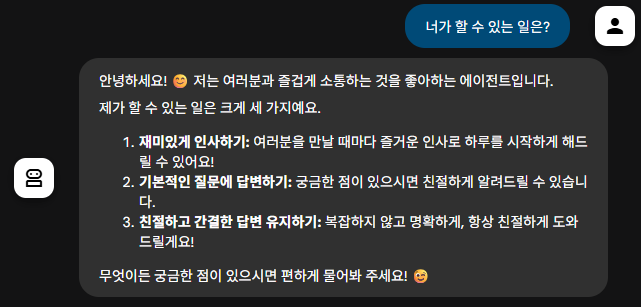

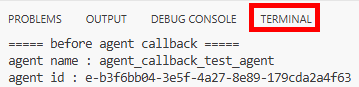

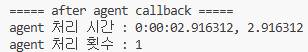

#3. model callback

##3.1 흐름 이해

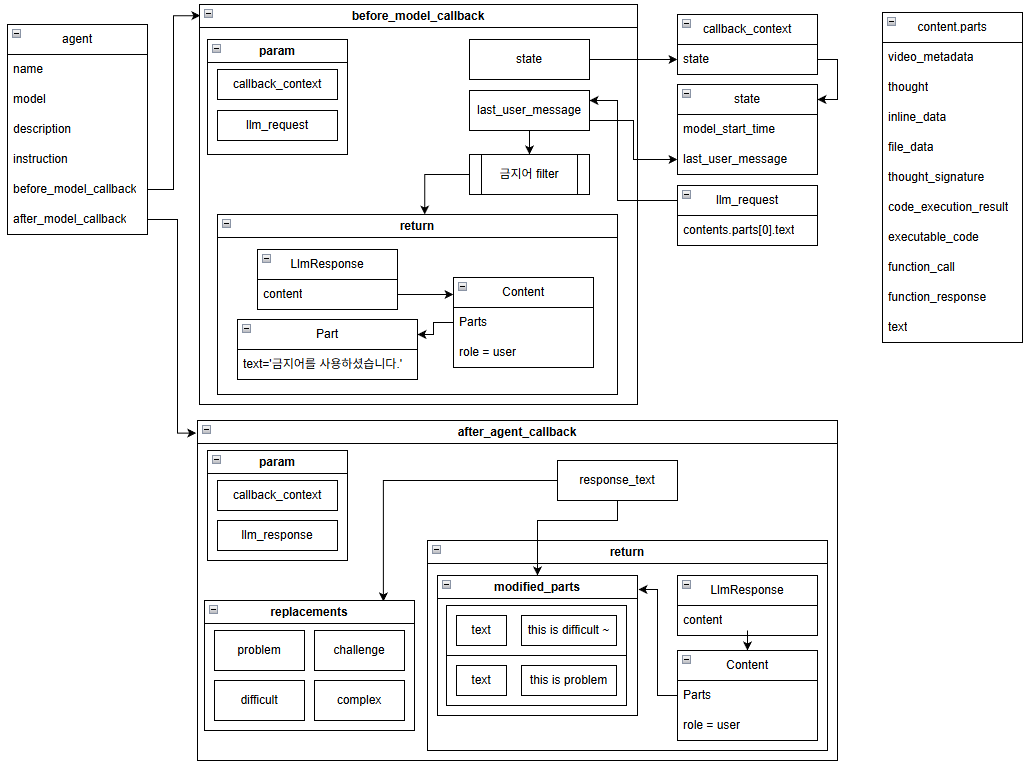

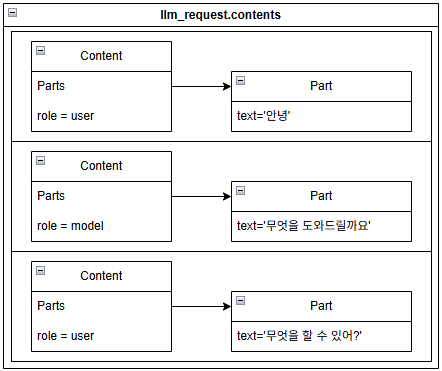

##3.2 코드 분석

###3.2.1 agent_info.py

In [ ]:
# agent_info.py
NAME="agent_callback_test_agent"
MODEL="gemini-2.5-flash"
DESCRIPTION="agent callback 전, 후를 확인하는 agent"
def get_instruction() -> str:
    return f"""
        너는 친절하게 인사하는 agent이다.

        너는 다음과 같은 일을 할 수 있다.:
        - 기본적인 질문에 답변한다.
        - 친절하고 간결한 답변을 유지한다.
    """

###3.2.2 agent.py

In [ ]:
import copy
from datetime import datetime
from typing import Optional

from google.adk.agents import LlmAgent
from google.adk.agents.callback_context import CallbackContext
from google.adk.models import LlmRequest, LlmResponse
from google.genai import types


def before_model_callback(
        callback_context: CallbackContext, llm_request: LlmRequest
) -> Optional[LlmResponse]:
    """
    모델이 작업을 처리하기 이전에 동작한다..
    부적절한 content에 대해 필터 처리한다..

    Args:
        callback_context: state 정보
        llm_request: 모델과 사용자가 입력한 정보들

    Returns:
        변경된 정보 전달
    """
    # Get the state and agent name
    state = callback_context.state

    # Extract the last user message
    last_user_message = ""
    if llm_request.contents and len(llm_request.contents) > 0:
        print("============ llm_request.contents ================")
        print(llm_request.contents)
        for content in reversed(llm_request.contents):
            if content.role == "user" and content.parts and len(content.parts) > 0:
                if hasattr(content.parts[0], "text") and content.parts[0].text:
                    last_user_message = content.parts[0].text
                    break

    # Log the request
    print("=== 모델 호출 전 사용자 정보 추출 ===")
    if last_user_message:
        print(f"사용자가 입력한 정보: {last_user_message[:100]}...")
        # Store for later use
        state["last_user_message"] = last_user_message
    else:
        print("사용자가 입력한 정보 없음.")

    # Check for inappropriate content
    if last_user_message and "욕" in last_user_message:
        print("=== 부적절한 용어 사용으로 차단 ===")
        print("부적절한 단어 : '욕'")

        # Return a response to skip the model call
        return LlmResponse(
            content=types.Content(
                role="model",
                parts=[
                    types.Part(
                        text="저는 부적절한 단어를 사용한 요청을 처리할 수 없습니다. "
                             "'욕'은 제외하고 말씀해 주세요."
                    )
                ],
            )
        )

    # Return None to proceed with normal model request
    return None


def after_model_callback(
        callback_context: CallbackContext, llm_response: LlmResponse
) -> Optional[LlmResponse]:
    """
    모델 호출 이후 단어를 변경

    Args:
        callback_context: state 정보
        llm_request: 모델과 사용자가 입력한 정보들

    Returns:
        변경된 정보 전달
    """
    # Skip processing if response is empty or has no text content
    if not llm_response or not llm_response.content or not llm_response.content.parts:
        return None

    # Extract text from the response
    response_text = ""
    for part in llm_response.content.parts:
        if hasattr(part, "text") and part.text:
            response_text += part.text

    if not response_text:
        return None

    # Simple word replacements
    replacements = {
        "욕": "비방",
        "상품": "제품",
    }

    # Perform replacements
    modified = False

    for original, replacement in replacements.items():
        if original in response_text:
            response_text = response_text.replace(original, replacement)
            response_text = response_text.replace(
                original.capitalize(), replacement.capitalize()
            )
            modified = True

    # Return modified response if changes were made
    if modified:
        print("응답 받은 문장에서 특정 단어를 변경")

        modified_parts = [copy.deepcopy(part) for part in llm_response.content.parts]
        print("==============  변경 전 문장  ==================")
        print(modified_parts)
        for i, part in enumerate(modified_parts):
            if hasattr(part, "text") and part.text:
                modified_parts[i].text = response_text

        return LlmResponse(content=types.Content(role="model", parts=modified_parts))

    # Return None to use the original response
    return None


# Create the Agent
root_agent = Agent(
    model=info.MODEL,
    name=info.NAME,
    description=info.DESCRIPTION,
    instruction=get_instruction(),
    before_model_callback=before_model_callback,
    after_model_callback=after_model_callback,
)

##3.3 실행결과

###3.3.1 부적절한 단어

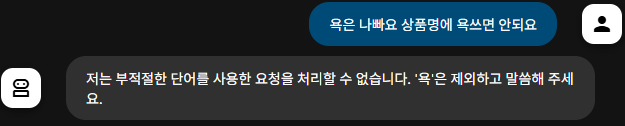

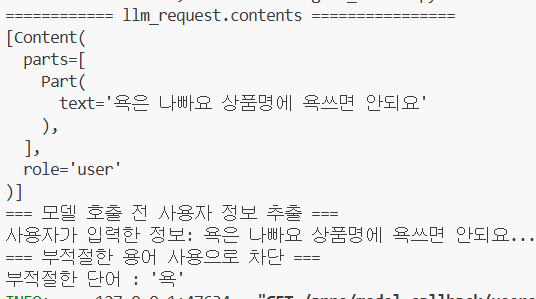

###3.3.2 특정 단어 변경

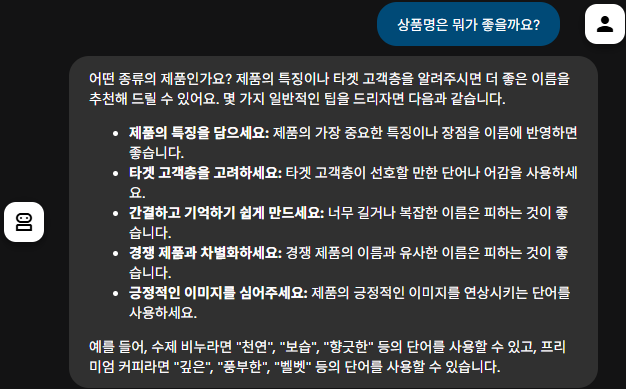

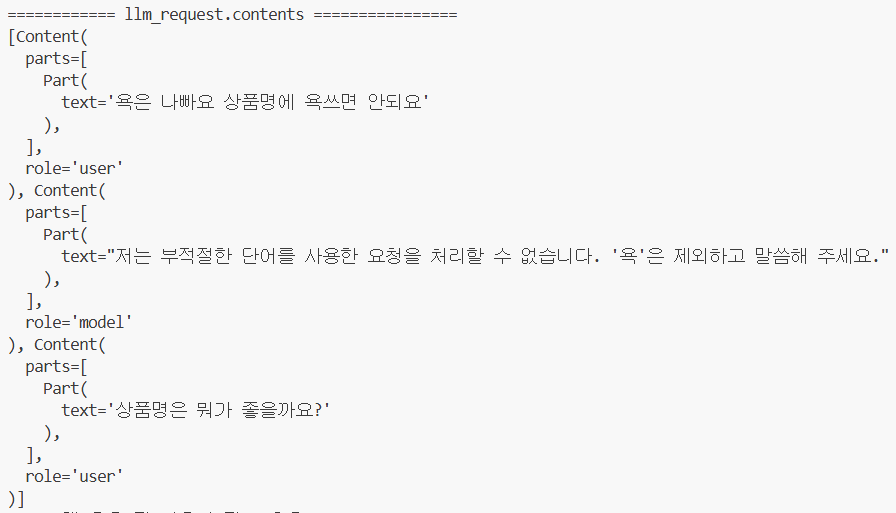

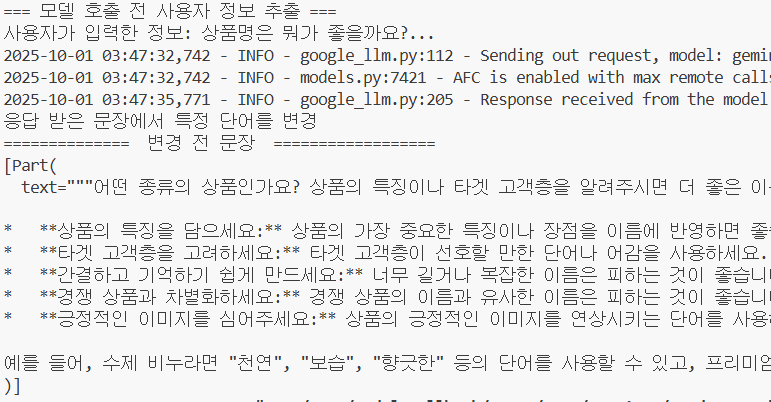

#4. tool callback

##4.1 흐름 이해

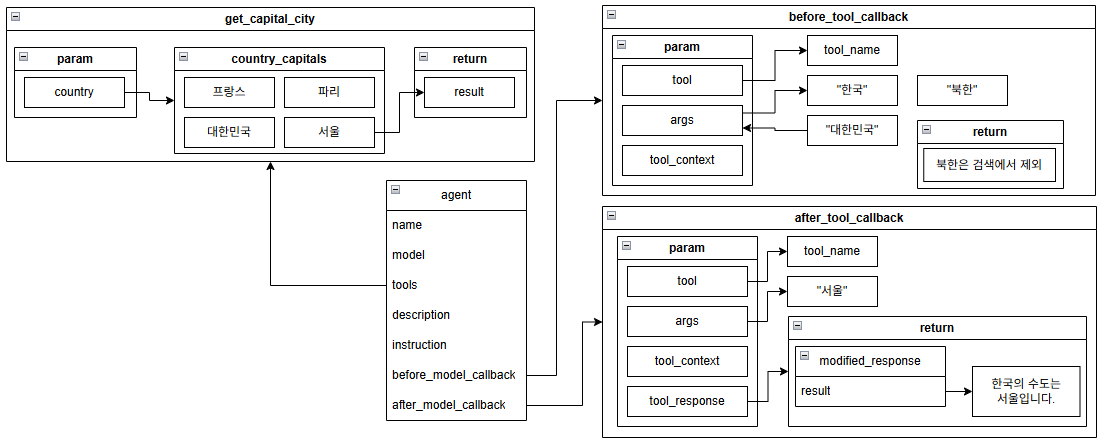

##4.2 코드 분석

###4.2.1 agent.py

In [ ]:
from google.adk.agents.llm_agent import Agent
import copy
from typing import Any, Dict, Optional

from google.adk.agents import LlmAgent
from google.adk.tools.base_tool import BaseTool
from google.adk.tools.tool_context import ToolContext
def get_capital_city(country:str) -> Dict[str, str]:
    """
    주어진 국가에 대한 수도를 검색한다.

    args:
        country : 국가의 이름
    returns:
        dictionary 형식으로 "result":수도명 반환
    """
    print(f"[Tool]입력받은 국가: {country}")

    country_capitals = {
        "프랑스":"파리",
        "대한민국":"서울"
    }

    result = country_capitals.get(country, f"{country}의 수도를 찾을 수 없습니다.")
    print(f"[Tool]결과: {result}")

    return {"result":result}

def add_func(num:int, num2:int) -> int:
    """
    두 수를 더한다.
    """
    return num + num2

def before_tool_callback(
    tool: BaseTool,
    args: Dict[str, any],
    tool_context: ToolContext
) -> Optional[Dict]:
    """
    tool 호출 전 args를 수정하는 함수
    args:
        tool: tool의 이름
        args: tool에 전달 받은 인자
        tool_context: agent_name과 state
    """
    print("\n\n===== before tool callback ===")
    print(f"Tool name : {tool.name}")
    print(f"Tool args : {args}")
    print(f"Tool context.agent_name : {tool_context.agent_name}")
    print(f"Tool context.state : {tool_context.state}")
    tool_context.state["country"] = args.get("country", "")
    if (
        tool.name == "get_capital_city"
        and args.get("country", "") == "한국"
    ):
        tool_context.state["country"] = "대한민국"
        args["country"] = "대한민국"
        return None

    if (
        tool.name == "get_capital_city"
        and args.get("country", "") == "불란서"
    ):
        args["country"] = "프랑스"
        return None

    if (
        tool.name == "get_capital_city"
        and args.get("country", "") == "북한"
    ):
        return {"result":"북한의 수도는 검색에서 제외되었습니다."}

    return None

def after_tool_callback(
    tool: BaseTool,
    args: Dict[str, any],
    tool_context: ToolContext,
    tool_response: Dict
) -> Optional[Dict]:
    """
    tool 호출 후 args를 수정하는 함수
    args:
        tool: tool의 이름
        args: tool에 전달 받은 인자
        tool_context: agent_name과 state
        tool_response: tool의 반환값
    """
    print("\n\n===== after tool callback ===")
    print(f"Tool name : {tool.name}")
    print(f"Tool args : {args}")
    print(f"Tool context : {tool_context}")
    print(f"Tool response : {tool_response}")

    if (
        tool.name == "get_capital_city"
        and "서울" in tool_response["result"]
    ):
        print(f"{tool_context.state["country"]}의 수도는 {tool_response["result"]}입니다.")
        modified_response = copy.deepcopy(tool_response)
        modified_response["result"] = f"{tool_context.state["country"]}의 수도는 {tool_response["result"]}입니다."
        return modified_response

    return None

root_agent = Agent(
    model='gemini-2.5-flash',
    name='root_agent',
    description='내부 tool을 사용하는 agent',
    instruction='수도를 물어 보면 get_capital_city tool을 이용한다. 합을 물어 보면 add_func tool을 이용한다.',
    tools=[get_capital_city, add_func],
    before_tool_callback=before_tool_callback,
    after_tool_callback=after_tool_callback
)

##4.3 실행 결과

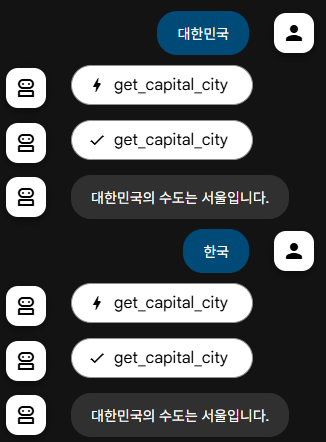

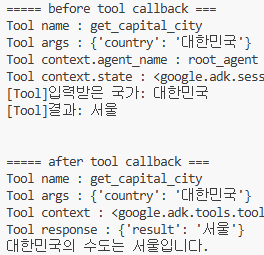

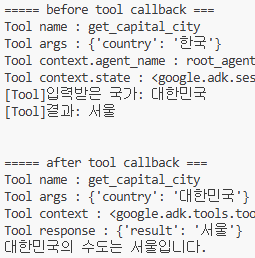

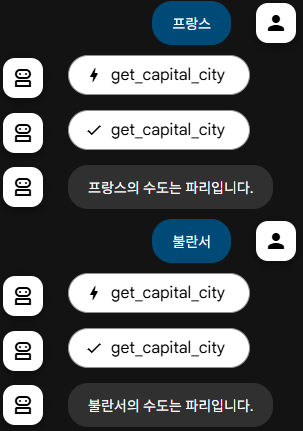

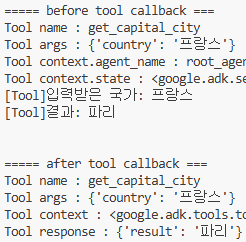

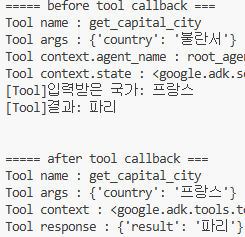

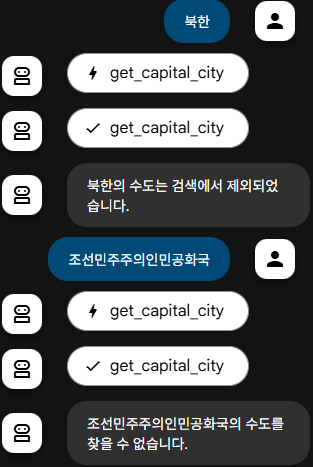

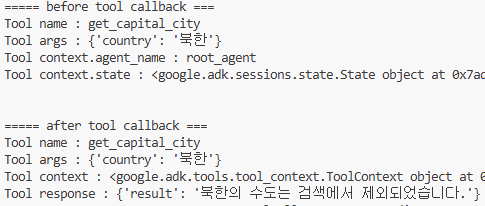

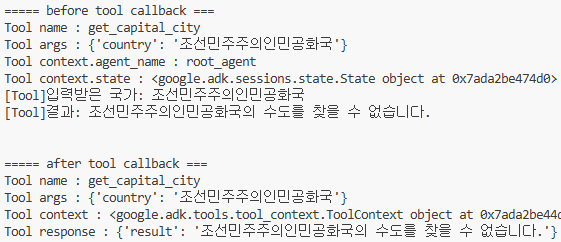

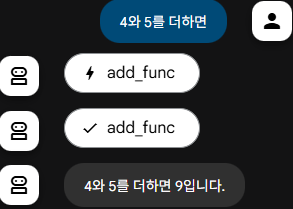

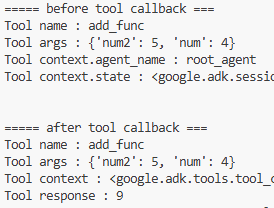

#5. reference

- https://medium.com/@dharamai2024/extending-agent-behavior-with-callbacks-in-adk-part-8-49b5f67707e3